### A practice of using this repo

In [1]:
import cv2
import numpy as np
import core.utils as utils
import tensorflow as tf
from PIL import Image
from matplotlib import pyplot as plt

/Users/yuezha01/anaconda3/envs/tensorflow_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/yuezha01/anaconda3/envs/tensorflow_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


### Original code

In [2]:
return_elements = ["input/input_data:0", "pred_sbbox/concat_2:0", "pred_mbbox/concat_2:0", "pred_lbbox/concat_2:0"]
pb_file         = "./yolov3_coco.pb"
image_path      = "./docs/images/sample_computer.jpg"
num_classes     = 80
input_size      = 416
graph           = tf.Graph()

### Modified for TF Serving by YZ 08/18/2019

In [2]:
return_elements = ["input/input_data:0", "pred_sbbox/concat_2:0", "pred_mbbox/concat_2:0", "pred_lbbox/concat_2:0", "pred_multi_scale/concat:0"]
pb_file         = "./yolov3_coco_v2.pb"
image_path      = "./docs/images/sample_computer.jpg"
num_classes     = 80
input_size      = 416
graph           = tf.Graph()

### Load and pre-process images

In [3]:
original_image = cv2.imread(image_path)

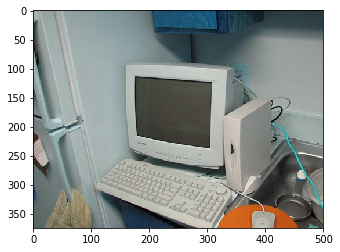

In [4]:
plt.imshow(original_image)
plt.show()

In [5]:
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

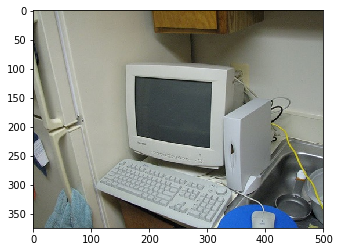

In [6]:
plt.imshow(original_image)
plt.show()

In [7]:
original_image_size = original_image.shape[:2]
original_image_size

(375, 500)

In [8]:
image_data = utils.image_preporcess(np.copy(original_image), [input_size, input_size])
print(image_data.shape)

(416, 416, 3)


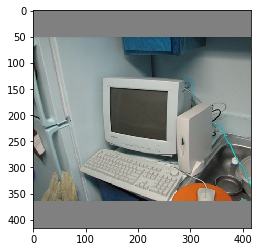

In [9]:
plt.imshow(image_data)
plt.show()

In [10]:
image_data = image_data[np.newaxis, ...]
print(image_data.shape)

(1, 416, 416, 3)


### Load the .pb file by using `tf.Graph` and `tf.GraphDef` in `read_pb_return_tensors`
* A [Graph](https://www.tensorflow.org/api_docs/python/tf/Graph) contains a set of `tf.Operation` objects and `tf.Tensor` objects.
* A default `Graph` is always registered. To add an operation to the default graph, simply call one of the functions that defines a new `Operation`.
* Another typical usage involves the [tf.Graph.as_default](https://www.tensorflow.org/api_docs/python/tf/Graph) context manager, which overrides the current default graph for the lifetime of the context and defining operations and tensors in the current default graph. 
* `tf.import_graph_def` provides a way to import a serialized TensorFlow `GraphDef` protocol buffer, extract individual objects in the `GraphDef` as `tf.Tensor` and `tf.Operation` objects, and [return specific tensors or operations](https://stackoverflow.com/questions/37146272/how-do-i-get-tensorflows-import-graph-def-to-return-tensors). The key thing is that `tf.import_graph_def` can only return operations and tensors for inference.. It can't restore variables or sessions. Meta Graph is needed. <b> Review how to create names???</b>
* [The difference between `Graph` and `GraphDef`](https://stackoverflow.com/questions/47059848/difference-between-tensorflows-graph-and-graphdef)

In [26]:
g1 = tf.Graph()

In [12]:
with tf.gfile.FastGFile(pb_file, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())

In [27]:
with g1.as_default():
    res = tf.import_graph_def(graph_def, return_elements=return_elements)
    saver = tf.train.Saver()
    with tf.Session(graph=g1) as sess:
        tf.trainable_variables()

ValueError: No variables to save

In [24]:
res

[<tf.Tensor 'import_3/input/input_data:0' shape=<unknown> dtype=float32>,
 <tf.Tensor 'import_3/pred_sbbox/concat_2:0' shape=(?, ?, ?, 3, 85) dtype=float32>,
 <tf.Tensor 'import_3/pred_mbbox/concat_2:0' shape=(?, ?, ?, 3, 85) dtype=float32>,
 <tf.Tensor 'import_3/pred_lbbox/concat_2:0' shape=(?, ?, ?, 3, 85) dtype=float32>]

In [11]:
# this is the main implementation of yolo
# Given an empty graph, a pb file, it returns the input tensor, and three-scale output tensors
# the empty graph copies the operations from the pb file
return_tensors = utils.read_pb_return_tensors(graph, pb_file, return_elements)

W0823 00:03:07.738501 4757571008 deprecation.py:323] From /Users/yuezha01/projects/yolo/tensorflow-yolov3/core/utils.py:122: FastGFile.__init__ (from tensorflow.python.platform.gfile) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.gfile.GFile.
W0823 00:03:07.740581 4757571008 deprecation_wrapper.py:119] From /Users/yuezha01/projects/yolo/tensorflow-yolov3/core/utils.py:123: The name tf.GraphDef is deprecated. Please use tf.compat.v1.GraphDef instead.



In [12]:
return_tensors

[<tf.Tensor 'import/input/input_data:0' shape=<unknown> dtype=float32>,
 <tf.Tensor 'import/pred_sbbox/concat_2:0' shape=(?, ?, ?, 3, 85) dtype=float32>,
 <tf.Tensor 'import/pred_mbbox/concat_2:0' shape=(?, ?, ?, 3, 85) dtype=float32>,
 <tf.Tensor 'import/pred_lbbox/concat_2:0' shape=(?, ?, ?, 3, 85) dtype=float32>,
 <tf.Tensor 'import/pred_multi_scale/concat:0' shape=(?, 85) dtype=float32>]

In [14]:
x_op = graph.get_operation_by_name('import/input/input_data')

In [16]:
x_op.outputs[0]

<tf.Tensor 'import/input/input_data:0' shape=<unknown> dtype=float32>

In [17]:
pred_op = graph.get_operation_by_name('import/pred_sbbox/concat_2')

In [23]:
pred_op.outputs[0]

<tf.Tensor 'import/pred_sbbox/concat_2:0' shape=(?, ?, ?, 3, 85) dtype=float32>

In [11]:
from tensorflow.saved_model import utils, signature_def_utils, signature_constants, tag_constants

In [25]:
utils.build_tensor_info(x_op.outputs[0])

W0818 15:47:49.626529 4635538880 deprecation.py:323] From <ipython-input-25-26ef0df77ec6>:1: build_tensor_info (from tensorflow.python.saved_model.utils_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


name: "import/input/input_data:0"
dtype: DT_FLOAT
tensor_shape {
  unknown_rank: true
}

In [26]:
utils.build_tensor_info(pred_op.outputs[0])

name: "import/pred_sbbox/concat_2:0"
dtype: DT_FLOAT
tensor_shape {
  dim {
    size: -1
  }
  dim {
    size: -1
  }
  dim {
    size: -1
  }
  dim {
    size: 3
  }
  dim {
    size: 85
  }
}

In [34]:
image_data.shape

(416, 416, 3)

In [15]:
graph.get_operation_by_name('pred_multi_scale').outputs

[<tf.Tensor 'pred_multi_scale:0' shape=(?, 85) dtype=float32>]

In [26]:
from tensorflow.saved_model import signature_def_utils, signature_constants, tag_constants
from tensorflow.saved_model import utils as save_model_utils

In [29]:
save_model_utils.build_tensor_info(x)

W0818 16:23:48.728411 4753171904 deprecation.py:323] From <ipython-input-29-3bf3a0d3ce6d>:1: build_tensor_info (from tensorflow.python.saved_model.utils_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


name: "import/input/input_data:0"
dtype: DT_FLOAT
tensor_shape {
  unknown_rank: true
}

In [34]:
with graph.as_default():
    return_tensors = utils.read_pb_return_tensors(graph, pb_file, return_elements)
    pred_multi_scale = tf.concat([tf.reshape(return_tensors[1], [-1, 85]), 
                                  tf.reshape(return_tensors[2], [-1, 85]), 
                                  tf.reshape(return_tensors[3], [-1, 85])], axis=0, name='pred_multi_scale')
    print(pred_multi_scale)
    with tf.Session(graph=graph) as sess:
        pred_boxes = sess.run(pred_multi_scale, feed_dict = {return_tensors[0]: image_data})
        x_op = sess.graph.get_operation_by_name('import/input/input_data')
        x = x_op.outputs[0]
        pred_op = sess.graph.get_operation_by_name('pred_multi_scale')
        pred = pred_op.outputs[0]
        
        print("prediction signature")
        prediction_signature = signature_def_utils.build_signature_def(
            inputs={"input": save_model_utils.build_tensor_info(x)},
            outputs={"output":save_model_utils.build_tensor_info(pred)},
            method_name=signature_constants.PREDICT_METHOD_NAME)
        
        builder = tf.saved_model.builder.SavedModelBuilder('./savemodel/yolo_v3/1')
        builder.add_meta_graph_and_variables(sess, [tag_constants.SERVING], 
                                     signature_def_map={"predict": prediction_signature})
        
        print("save...")
        builder.save()

Tensor("pred_multi_scale_3:0", shape=(?, 85), dtype=float32)
prediction signature
save...


### The variable folder generated by the above approach is empty because the sess loads a .pb file with only the graph structure but no variables.

In [19]:
sess.graph is graph

True

In [16]:
sess.close()

In [18]:
len(graph.get_operations())

1429

In [12]:
with tf.Session(graph=graph) as sess:
    pred_sbbox, pred_mbbox, pred_lbbox = sess.run([return_tensors[1], return_tensors[2], return_tensors[3]],
                                                            feed_dict = {return_tensors[0]: image_data})

In [10]:
with tf.Session(graph=graph) as sess:
    pred_sbbox, pred_mbbox, pred_lbbox, pred_all = sess.run([return_tensors[1], return_tensors[2], return_tensors[3], return_tensors[4]],
                                                            feed_dict = {return_tensors[0]: image_data})

In [11]:
print(pred_sbbox.shape, pred_mbbox.shape, pred_lbbox.shape, pred_all.shape)

(1, 52, 52, 3, 85) (1, 26, 26, 3, 85) (1, 13, 13, 3, 85) (10647, 85)


In [13]:
pred_bbox = np.concatenate([np.reshape(pred_sbbox, (-1, 5 + num_classes)),
                            np.reshape(pred_mbbox, (-1, 5 + num_classes)),
                            np.reshape(pred_lbbox, (-1, 5 + num_classes))], axis=0)

In [14]:
pred_bbox.shape

(10647, 85)

In [14]:
(pred_all - pred_bbox).sum()

0.0

### Post-process the output bounding boxes

In [15]:
# post-processing 
bboxes = utils.postprocess_boxes(pred_bbox, original_image_size, input_size, 0.3)

In [16]:
bboxes.shape

(11, 6)

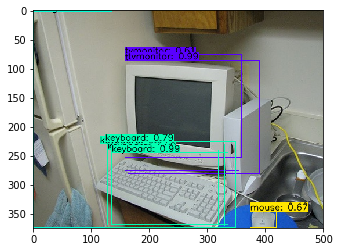

In [22]:
image = utils.draw_bbox(original_image, bboxes)
plt.imshow(image)
plt.savefig("/Users/yuezha01/projects/RAID-Constellation/presentation/sample_computer_v1.png")

In [17]:
bboxes_v2 = utils.postprocess_boxes(pred_all, original_image_size, input_size, 0.3)

In [18]:
bboxes_v2.shape

(11, 6)

In [19]:
(bboxes - bboxes_v2).sum()

0.0

In [20]:
# non-max suppression
bboxes = utils.nms(bboxes, 0.45, method='nms')
bboxes

[array([374.56097412, 346.6842041 , 420.29605103, 374.        ,
          0.66586232,  64.        ]),
 array([128.75416565, 240.80760193, 319.69570923, 369.58120728,
          0.99569577,  66.        ]),
 array([  0.        ,   3.95087099, 177.60038757, 374.        ,
          0.8430534 ,  72.        ]),
 array([158.31402588,  87.69712067, 355.63342285, 276.15744019,
          0.99779314,  62.        ])]

In [21]:
# non-max suppression
bboxes_v2 = utils.nms(bboxes_v2, 0.45, method='nms')
bboxes_v2

[array([374.56097412, 346.6842041 , 420.29605103, 374.        ,
          0.66586232,  64.        ]),
 array([128.75416565, 240.80760193, 319.69570923, 369.58120728,
          0.99569577,  66.        ]),
 array([  0.        ,   3.95087099, 177.60038757, 374.        ,
          0.8430534 ,  72.        ]),
 array([158.31402588,  87.69712067, 355.63342285, 276.15744019,
          0.99779314,  62.        ])]

In [17]:
image = utils.draw_bbox(original_image, bboxes)

In [18]:
image.shape

(375, 500, 3)

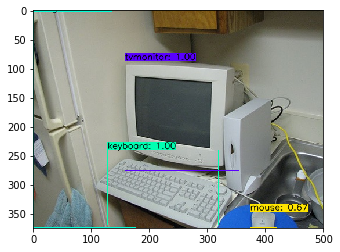

In [20]:
plt.imshow(image)
plt.show()

In [22]:
image_v2 = utils.draw_bbox(original_image, bboxes_v2)

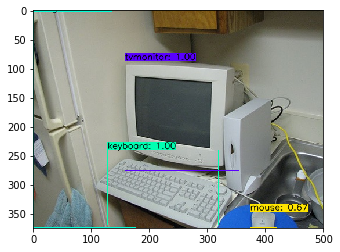

In [23]:
plt.imshow(image_v2)
plt.show()

### Understand postprocess_boxes()

In [60]:
print(pred_bbox.shape)
org_img_shape = original_image_size
print(org_img_shape)
print(input_size)
score_threshold = 0.3

(10647, 85)
(375, 500)
416


In [62]:
pred_xywh = pred_bbox[:, 0:4]
pred_conf = pred_bbox[:, 4]
pred_prob = pred_bbox[:, 5:]

In [67]:
pred_xywh.shape

(10647, 4)

### understand nms

In [45]:
iou_threshold = 0.45
sigma = 0.3
method = 'nms'

In [34]:
print("There are {0} bounding boxes with {1} elements: 4 coordinates, 1 confidence score, 1 class prediction".format(bboxes.shape[0], bboxes.shape[1]))

There are 11 bounding boxes with 6 elements: 4 coordinates, 1 confidence score, 1 class prediction


In [30]:
classes_in_img = list(set(bboxes[:, 5]))
print(classes_in_img)
best_bboxes = []

[64.0, 66.0, 72.0, 62.0]


In [36]:
cls = classes_in_img[1]
cls_mask = (bboxes[:, 5] == cls)
cls_bboxes = bboxes[cls_mask]
print("There are {0} bounding boxes predicted for this class in the image.".format(cls_bboxes.shape[0]))

There are 4 bounding boxes predicted for this class in the image.


In [37]:
max_ind = np.argmax(cls_bboxes[:, 4])
best_bbox = cls_bboxes[max_ind]
best_bboxes.append(best_bbox)
# find the best bbox with the max score for one class and remove it from 
cls_bboxes = np.concatenate([cls_bboxes[: max_ind], cls_bboxes[max_ind + 1:]])

In [43]:
iou = utils.bboxes_iou(best_bbox[np.newaxis, :4], cls_bboxes[:, :4])
weight = np.ones((len(iou),), dtype=np.float32)
print("the IoU between this bbox and other bboxes are {}".format(iou))

the IoU between this bbox and other bboxes are [0.80863016 0.84848163 0.73888701]


In [46]:
iou_mask = iou > iou_threshold

In [47]:
weight[iou_mask] = 0.0

In [48]:
weight

array([0., 0., 0.], dtype=float32)

In [49]:
cls_bboxes[:, 4] = cls_bboxes[:, 4] * weight
score_mask = cls_bboxes[:, 4] > 0.
cls_bboxes = cls_bboxes[score_mask]

In [50]:
cls_bboxes

array([], shape=(0, 6), dtype=float64)

#### all the other bboxes for this class overlap a lot with the best_bbox, so all of them are removed

### Converting weights to a .pb file